## 데이터로더 이미지 출력 테스트

In [1]:
# 모듈 임포트 경로 추가
import sys, os
sys.path.append(os.path.abspath(".."))

In [2]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from src.transforms import NormalizeInverse
from src.datasources import JIF_S2_MEAN, JIF_S2_STD, S2_ALL_12BANDS
from multiprocessing import Manager
from src.datasets import load_dataset_JIF

dataset_root=os.path.join("..", "dataset")

aoi_csv_path = os.path.join(dataset_root, 'train_val_test_split.csv')
list_of_aois = pd.read_csv(aoi_csv_path)

multiprocessing_manager = Manager()

config = dict(
    input_size=(160, 160),
    output_size=(640, 640),
    chip_size=(160, 160),
    batch_size=10,
    batch_size_test=1,
    normalize_lr=True,
    root=dataset_root,
    multiprocessing_manager=multiprocessing_manager,
    list_of_aois=list_of_aois,
    shuffle=True,
    use_single_frame_sr=True, # single frame SR 사용
    calculate_median_std=False,
    radiometry_depth=12,
    lr_bands_to_use="true_color", # RGB 3채널만 사용
    randomly_rotate_and_flip_images=True,
    num_workers=0,
    max_epochs=-1,
)

dataloaders = load_dataset_JIF(**config)
train_dataloader = dataloaders["train"] # train, val, test
train_dataset = dataloaders["train"].dataset

print("--------------------------------")
print(f'lr shape: {train_dataset[0]["lr"].shape}') # 0번 샘플의 LR 이미지 크기
print(f'lrc shape: {train_dataset[0]["lrc"].shape}') # 0번 샘플의 LRC(Cloud Mask) 이미지 크기
print(f'hr shape: {train_dataset[0]["hr"].shape}') # 0번 샘플의 HR 이미지 크기
print("--------------------------------")

for i, batch in enumerate(train_dataloader):
    if i == 1:
        break

    print(f'batched lr shape: {batch["lr"].shape}')
    print(f'batched lrc shape: {batch["lrc"].shape}')
    print(f'batched hr shape: {batch["hr"].shape}')

/opt/homebrew/anaconda3/envs/temp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using SingleFrameSatelliteDataset for LR channel.
Using SingleFrameSatelliteDataset for LRC channel.
Using SingleFrameSatelliteDataset for LR channel.
Using SingleFrameSatelliteDataset for LRC channel.
Using SingleFrameSatelliteDataset for LR channel.
Using SingleFrameSatelliteDataset for LRC channel.
Shuffling the dataset splits using 42
Shuffling the dataset splits using 42
Shuffling the dataset splits using 42
Shuffling the dataset splits using 42
Train set size: 1189
Val set size: 150
Test set size: 165
--------------------------------
lr shape: torch.Size([3, 160, 160])
lrc shape: torch.Size([1, 160, 160])
hr shape: torch.Size([3, 640, 640])
--------------------------------


/opt/homebrew/anaconda3/envs/temp/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


batched lr shape: torch.Size([10, 3, 160, 160])
batched lrc shape: torch.Size([10, 1, 160, 160])
batched hr shape: torch.Size([10, 3, 640, 640])


## 데이터 시각화
- LR이미지는 원본 센서 값에 대해 z-score로 정규화된 상태이므로 시각화를 위해 역정규화 필요
  - 역정규화된 이미지도 실수 1.0을 벗어날 수 있으므로 normalize_img 함수를 통해 min-max 스케일링 필요
- HR이미지는 min(0)-max(10000) 스케일링된 값으로 0.0 ~ 1.0 사이 값을 가지지만 센서에서 측정한 원시 데이터이므로 매우 어둡게 보일 수 있음(위성 영상의 실제 반사율 값은 도시를 제외하면 대부분 낮은 범위에 분포하기 때문)
  - normalize_img 함수를 사용하면 최소/최댓값을 0과 1로 맞추어 명암 대비 스트레칭 효과로 더 밝게 보일 수 있음

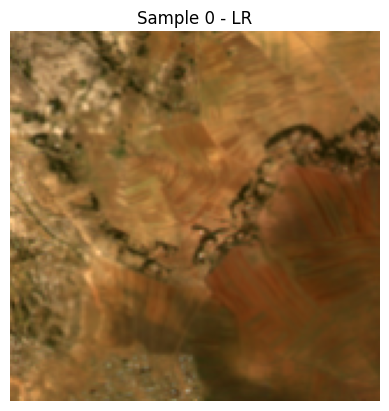

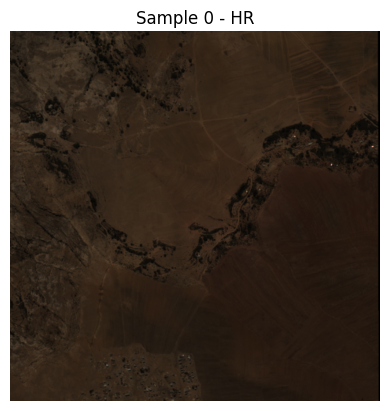

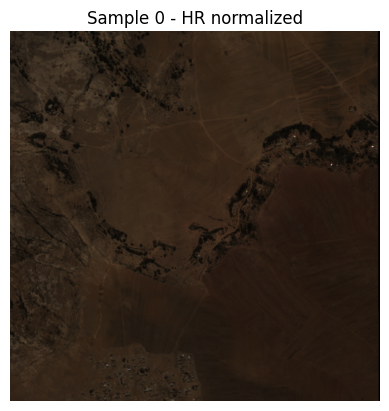

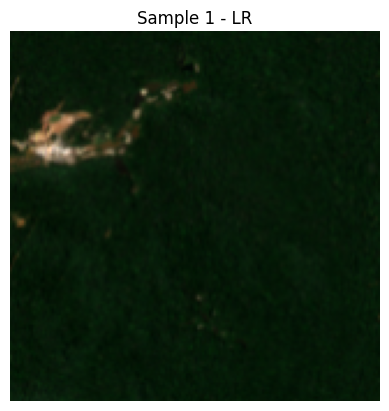

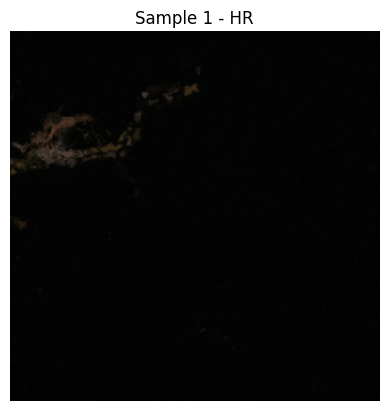

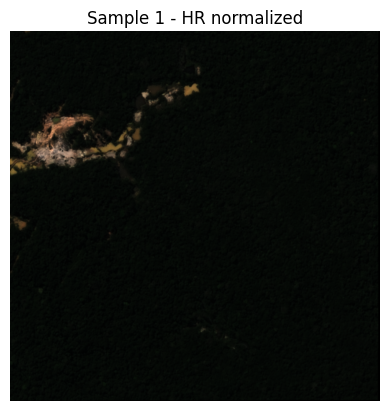

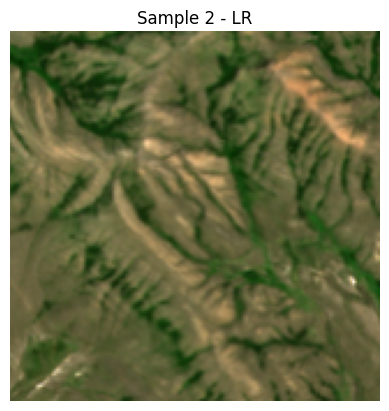

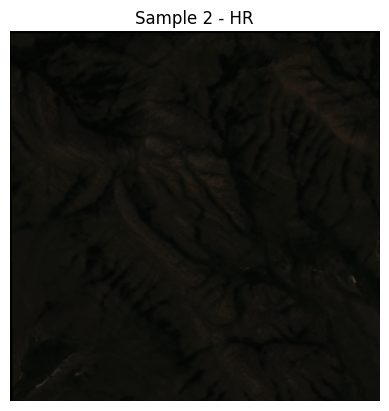

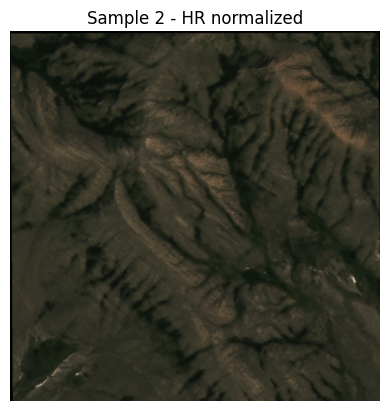

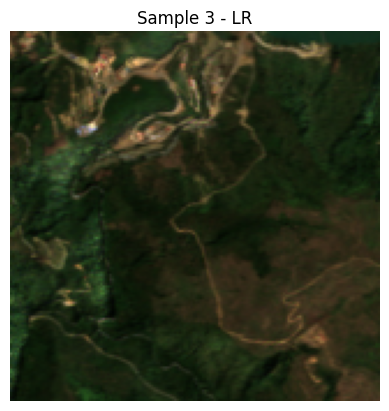

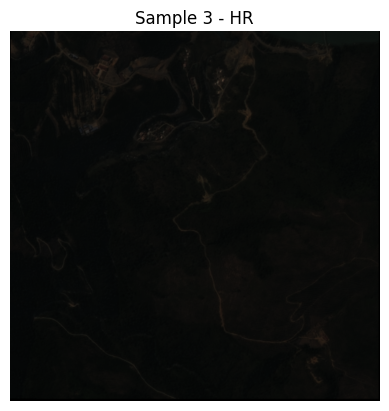

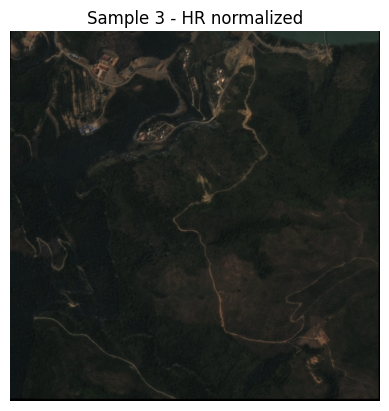

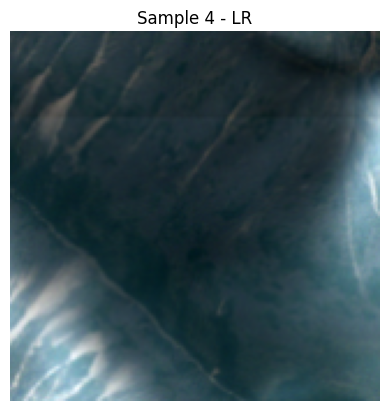

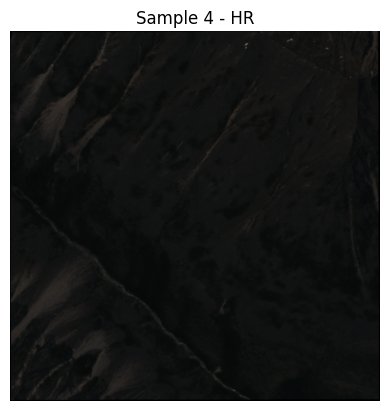

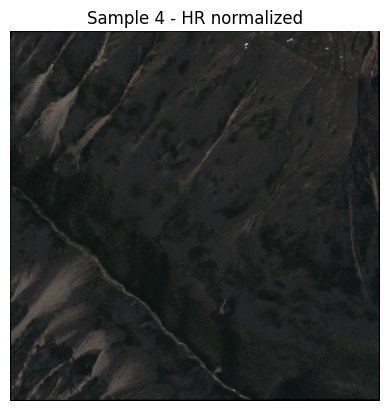

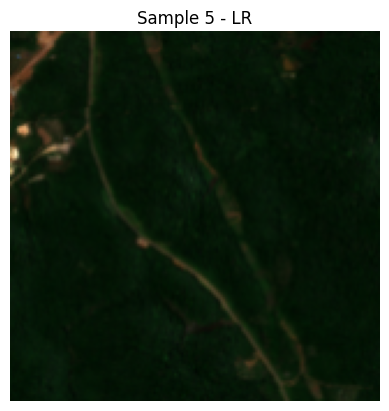

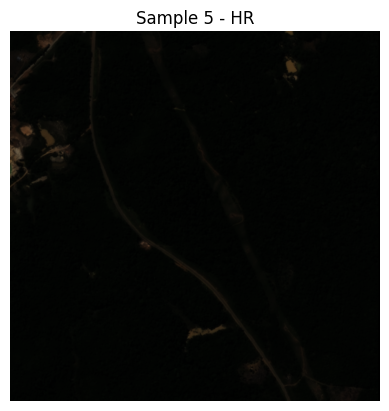

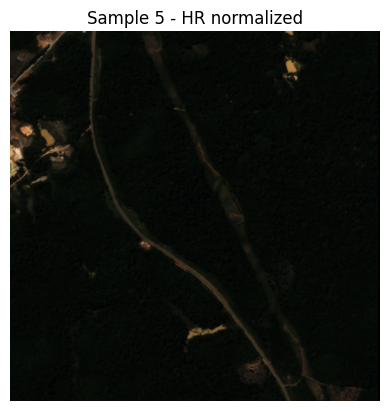

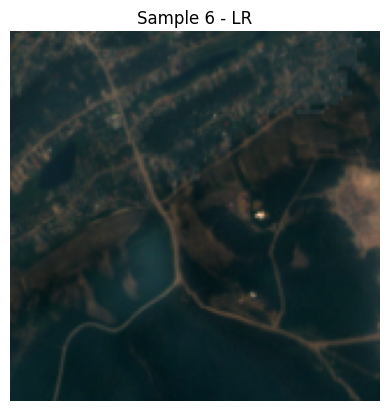

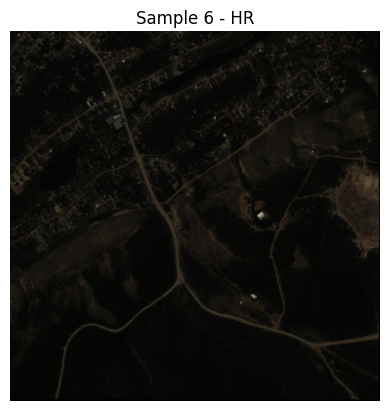

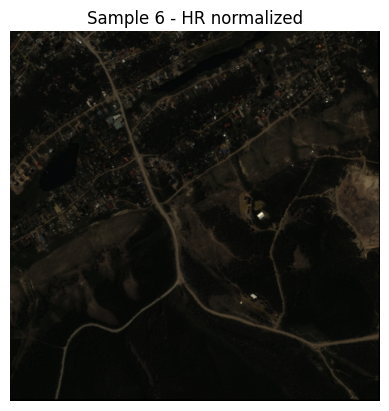

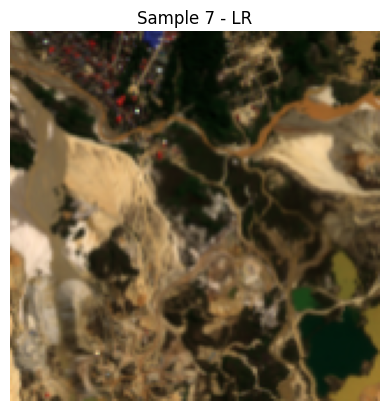

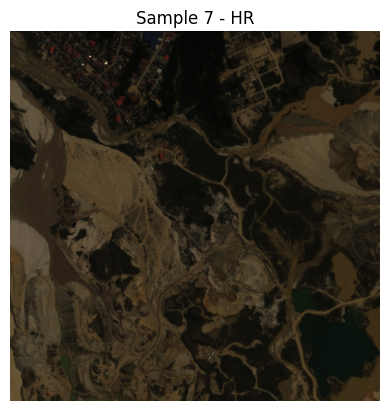

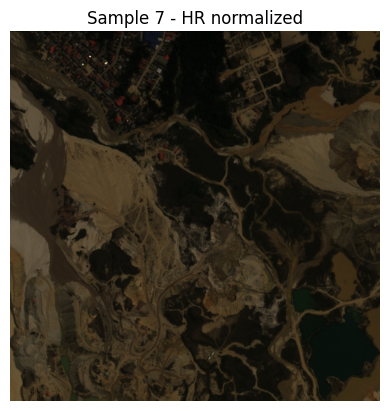

In [3]:
# lr 데이터는 전처리 시 z-score 정규화가 되어있기 때문에 역정규화가 필요합니다.
lr_bands_index = np.array(S2_ALL_12BANDS["true_color"]) - 1
lr_mean = JIF_S2_MEAN[lr_bands_index]
lr_std = JIF_S2_STD[lr_bands_index]

inv_normalize_lr = NormalizeInverse(mean=lr_mean, std=lr_std)

# 첫 번째 배치 가져오기
batch = next(iter(train_dataloader))

# 배치 안에서 최대 8개까지 시각화
num_samples = min(8, batch["lr"].shape[0])

for i in range(num_samples):
    # 각 이미지 가져오기 (C, H, W) → (H, W, C) 
    lr_denormalized = inv_normalize_lr(batch["lr"][i])
    lr_denormalized = lr_denormalized.numpy().transpose(1, 2, 0)
    lr_denormalized = np.clip(lr_denormalized, 0, 1) # 0~1 범위로 클리핑

    lrc = batch["lrc"][i].numpy().transpose(1, 2, 0)
    hr = batch["hr"][i].numpy().transpose(1, 2, 0)

    # min-max 스케일링
    def normalize_img(img):
        img = img - np.min(img)
        img = img / (np.max(img) + 1e-8)
        return img

    # LR 이미지 출력
    plt.figure()
    plt.imshow(normalize_img(lr_denormalized))
    plt.title(f"Sample {i} - LR")
    plt.axis('off')
    plt.show()

    # HR 이미지 출력
    plt.figure()
    plt.imshow(hr)
    plt.title(f"Sample {i} - HR")
    plt.axis('off')
    plt.show()

    # 정규화 HR 이미지 출력
    plt.figure()
    plt.imshow(normalize_img(hr))
    plt.title(f"Sample {i} - HR normalized")
    plt.axis('off')
    plt.show()